In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage, cv2
from skimage import io, transform
%matplotlib inline

In [2]:
joints=pd.read_csv("./dataset.csv",header=None).as_matrix()

In [3]:
img_path=list(path for path in joints[:,0])
joint_coors=list(coors for coors in joints[:,1:29])
joint_is_valid=list(is_valid for is_valid in joints[:,29:])

In [4]:
def process(img_path, joint_coors, joint_is_valid, re_img_size=(256,256), is_valid=False):
    img_set=np.zeros([len(img_path),re_img_size[0],re_img_size[1],3],dtype=np.float)
    coor_set=np.array(joint_coors).reshape(len(joint_coors),14,2)
    
    for i, path in enumerate(img_path):
        img=skimage.io.imread(path)
        img_set[i]=skimage.transform.resize(img,(re_img_size[0],re_img_size[1],3))

        for j in range(14):
            if is_valid and bool(joint_is_valid[i][j]): coor_set[i][j] = [-1,-1]
            
            if coor_set[i][j][0]==-1: pass
            else: coor_set[i][j][0]=coor_set[i][j][0]*(re_img_size[0]/img.shape[1])
            
            if coor_set[i][j][1]==-1: pass
            else: coor_set[i][j][1]=coor_set[i][j][1]*(re_img_size[1]/img.shape[0])
            
    return img_set, coor_set

In [5]:
def markJoints(img, joints, joint_is_valid, is_valid=False):  
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i in range(14):
        x, y = map(int,joints[i])
        if x!=-1: 
            if is_valid and bool(joint_is_valid[i]): continue
            else:
                rr, cc = skimage.draw.circle(y, x, 5) 
                skimage.draw.set_color(img, (rr, cc), (1,0,0)) 
                cv2.putText(img, str(i+1), (x,y), font, 0.5, (0.5,0.5,0.5), 2, cv2.LINE_AA)
    return img

In [6]:
picpic, coco = process(img_path, joint_coors, joint_is_valid)

/home/hahnz/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


/home/hahnz/.local/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


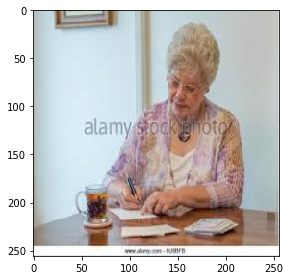

In [7]:
skimage.io.imshow(picpic[101])

/home/hahnz/.local/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


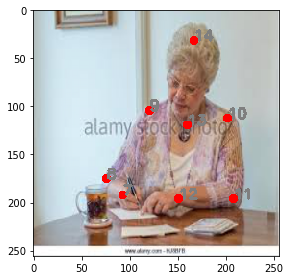

In [8]:
idx=101
test=markJoints(picpic[idx],coco[idx],joint_is_valid[idx])
skimage.io.imshow(test)